# Argument Feedback Effectiveness
----

# Introduction
----

[Data](https://www.kaggle.com/competitions/feedback-prize-effectiveness/data)

In this project different Bert implementations will be used to predict the effectiveness of different arguments.

The dataset contains a `discourse text`, `discourse type` and `discourse effectiveness`, where the latter is the label. The label can be either Adequate,
Effective or Ineffective. 

discourse type can be any of 'Claim', 'Concluding Statement', 'Counterclaim', 'Evidence', 'Lead', 'Position' or 'Rebuttal'.

All models will finetune a Bert model with the discourse text to predict its effectivness. The difference is in how the type is used. 
I will implement three models,
- One using only the *discourse type*
- One one hot encoding the discourse type and use it as an input to the final classifying layer
- And finally one taking advantage of the two sentence structure used for the original training of Bert:  [CLS] sen A [SEP] sen B [SEP]. 
    Where we replace sen A with the type and sen B with the text
    
The idea is to first test if the type has any affect on the model-performance. The second is to see if the embedding of the type as well as the two 
sentence strucutre of Bert has any affect on the performance. I will refer to the models as *only-text*, *oh* (one hot) and *sep* (or two-sentence)

In addition to this I will use a simple *baseline*, simply predicting the distribution of labels based on the type.

I will use Cross-entropy loss and Accuracy as metrics to measure performance.



In [1]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:


if  torch.cuda.is_available():
    print('Torch available?', torch.cuda.is_available(), torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))
    device = torch.device('cuda:0')
else:
    print('cuda not available - using cpu')
    device = torch.device('cpu')
    
TRAIN_MODEL = True # Run notebook without starting any training run

Torch available? True 1
Quadro P5000


# Data
------

In [3]:
path = 'resources/'
data = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

print('data:', np.shape(data))
display(data.head())
print()
print('test:', np.shape(test))
display(test.head())



data: (36765, 5)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate



test: (10, 4)


,discourse_id,essay_id,discourse_text,discourse_type
0,a261b6e14276,D72CB1C11673,Making choices in life can be very difficult. ...,Lead
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person ma...,Position
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim


mean: 249.320


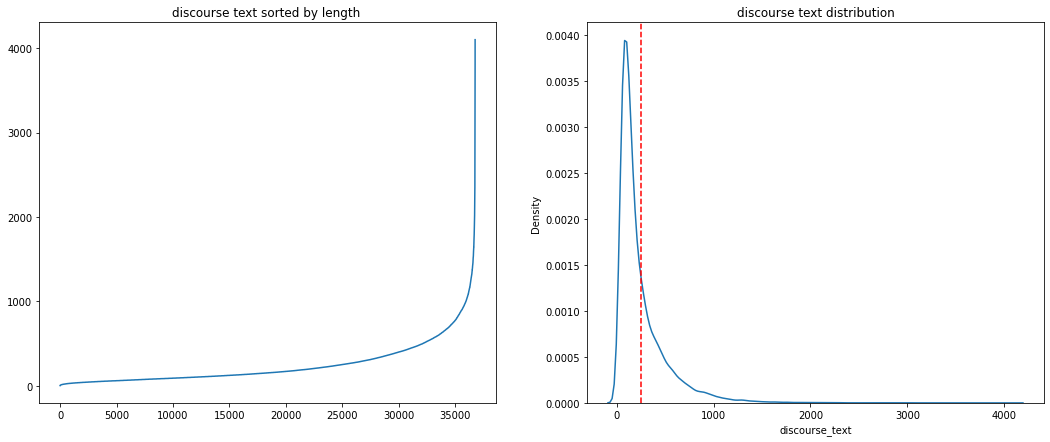

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,7))


ax1.plot(np.arange(len(data)), sorted(data['discourse_text'].apply(len)))

ax1.set_title('discourse text sorted by length ')

sns.kdeplot(data['discourse_text'].apply(len), ax=ax2)
ax2.set_title('discourse text distribution')
ax2.axvline(np.mean(data['discourse_text'].apply(len)), c='r', ls='--')
print('mean: %.3f'%(np.mean(data['discourse_text'].apply(len)))) 

In [5]:
data['discourse_effectiveness'].value_counts()

Adequate       20977
Effective       9326
Ineffective     6462
Name: discourse_effectiveness, dtype: int64

<AxesSubplot:ylabel='discourse_type'>

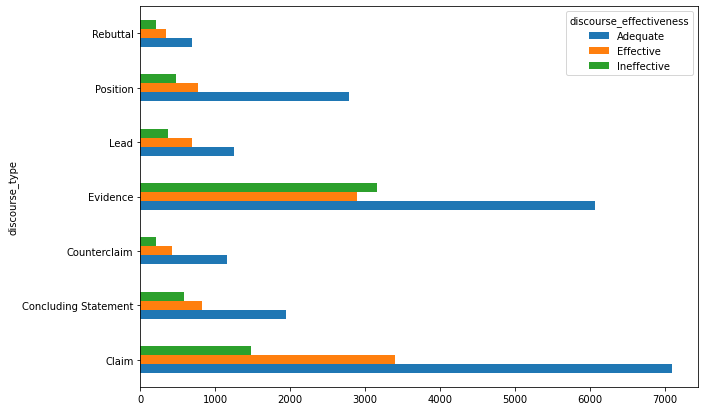

In [6]:
fig, ax = plt.subplots(1,1,figsize=(10,7))

data.groupby('discourse_type')['discourse_effectiveness'].value_counts().unstack(1).plot.barh(ax=ax)

In [7]:
#training, validation = train_test_split(data, test_size=0.1, random_state=1234)
#print('training:', len(training), 'test:', len(validation))

training, validation, test = np.split(data.sample(frac=1, random_state=1234), [int(.8*len(data)), int(.9*len(data))])

print('training:', len(training), 'vali:', len(validation), 'test:', len(test))

training: 29412 vali: 3676 test: 3677


**Notes**
- dont need to lower text - we will use already implemented tokenizers that will handle this for us
- Average text length of 250 -> max token length of 256 seems like a good idea.

# Baseline
-----

In [8]:
def cross_entropy_loss(true, preds):
    # so we use the same loss in Baseline as for BERT
    if isinstance(true, pd.Series):
        true = true.values
        print(1)
    if isinstance(preds, pd.Series):
        preds = preds.values
    
    out = nn.CrossEntropyLoss()(torch.tensor(preds, dtype=torch.float).to(device), torch.tensor(true, dtype=torch.float).to(device)) # input flipped from sklearn
    return out.item()

def baseline(training, validation):
    props = dict()
    for discourse_type, g in training.groupby('discourse_type'):
        props[discourse_type] = g['discourse_effectiveness'].value_counts()/np.sum(g['discourse_effectiveness'].value_counts())

    y_pred = [list(props[dis_type].values) for dis_type in validation['discourse_type']]
    y_pred_class = [['Adequate', 'Effective', 'Ineffective'][np.argmax(x)] for x in y_pred]

    y_true = list(validation['discourse_effectiveness'].apply(lambda x: [int(x==i) for i in ['Adequate', 'Effective', 'Ineffective']]))

    ll = cross_entropy_loss(y_true, y_pred)
    #ll = log_loss(validation['discourse_effectiveness'], y_pred)
    return ll, accuracy_score(validation['discourse_effectiveness'], y_pred_class)


In [9]:
ll, acc = baseline(training, validation)
#print('log-loss = %.3f, accuracy = %.3f'%(ll, acc))
print('cross-entropy loss = %.3f, accuracy = %.3f'%(ll, acc))

cross-entropy loss = 1.017, accuracy = 0.576


# BERT : TEXT <SEP\> TYPE



-----

In [54]:
!git remote -v

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
origin	https://github.com/iscyb/argument_effectiveness (fetch)
origin	https://github.com/iscyb/argument_effectiveness (push)


In [10]:
import transformers
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from transformers import BertModel

model_name = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Note** 
- Benefit of BERT is that is is trained using two sentences: sen A [SEP] sen B
    - We can utilize this is in our case using: text [SEP] type
    
    
https://www.kaggle.com/code/debarshichanda/pytorch-feedback-deberta-v3-baseline

In [11]:
class DiscourseDataset(Dataset):
    
    def __init__(self, data):
        
        self.data = data
        #self.discourse_labels = sorted(discourse_labels)
        #self.discourse_types = sorted(discourse_types)
        
        #self.device = device
        
        #self.max_token_len = max_token_len
        
    
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index) -> dict:
        discourse_text = self.data.iloc[index]['discourse_text']
        discourse_type = self.data.iloc[index]['discourse_type']
        discourse_effectiveness = self.data.iloc[index]['discourse_effectiveness']
        
        # one hot
        #discourse_type = torch.FloatTensor([1 if x == discourse_type else 0 for x in self.discourse_types]).to(self.device)
        #discourse_effectiveness = torch.FloatTensor([1 if x == discourse_effectiveness else 0 for x in self.discourse_labels]).to(self.device)
        
        return {'label': discourse_effectiveness, 
                'type' : discourse_type,
                'text' : discourse_text}
    
# TEST     
test_data = training.iloc[0:5]
testtest = DiscourseDataset(test_data)
display(testtest[0])


{'label': 'Ineffective',
 'type': 'Claim',
 'text': 'My second reason is it is very fast. '}

In [12]:
discourse_labels = sorted(np.unique(data['discourse_effectiveness']))
discourse_types = sorted(np.unique(data['discourse_type']))
print(discourse_labels)
print(discourse_types)

['Adequate', 'Effective', 'Ineffective']
['Claim', 'Concluding Statement', 'Counterclaim', 'Evidence', 'Lead', 'Position', 'Rebuttal']


In [13]:
print('sep token', tokenizer.sep_token)
print(tokenizer(tokenizer.sep_token, add_special_tokens=False))

sep token [SEP]
{'input_ids': [102], 'token_type_ids': [0], 'attention_mask': [1]}


In [14]:
print(tokenizer('dog' + tokenizer.sep_token + 'cat', add_special_tokens=True) )
print(tokenizer('dog' + tokenizer.sep_token + 'cat', add_special_tokens=False) )

{'input_ids': [101, 3899, 102, 4937, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}
{'input_ids': [3899, 102, 4937], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}


In [15]:

class BERT_TwoSentence_Collate():

    
    def __init__(self, tokenizer, discourse_labels, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.discourse_labels = discourse_labels
        #self.discourse_types = discourse_types
        
        
    def __call__(self, batch):
        labels = []
        output = [] # type [SEP] text
        
        for elem in batch:
            labels.append([int(elem['label']==x) for x in self.discourse_labels])
            output.append(elem['type']+self.tokenizer.sep_token+elem['text'])
        
        tokens = self.tokenizer(output, \
                                    add_special_tokens=True, 
                                    return_tensors='pt',
                                    truncation=True, 
                                    max_length=self.max_length, 
                                    padding=True, # changed from max len
                                    return_attention_mask=True,
                                    is_split_into_words=False)
        
        
        
        
        input_ids=tokens['input_ids'].to(device)
        attention_masks=tokens['attention_mask'].to(device)
        labels = torch.tensor(labels, dtype=torch.float).to(device)# flaot tensor is nessecary for #torch.stack(labels).to(device)
        
        return input_ids, attention_masks, labels

# TEST     
test_data = training.iloc[0:5]
testtest = DiscourseDataset(test_data)
test_loader = DataLoader(testtest,
        batch_size=2,
        shuffle=False,
        collate_fn=BERT_TwoSentence_Collate(tokenizer, discourse_labels, 10))

print(len(test_loader))
next(iter(test_loader))

3


(tensor([[ 101, 4366,  102, 2026, 2117, 3114, 2003, 2009, 2003,  102],
         [ 101, 4366,  102, 2054, 1996, 3861, 2941, 3065, 2003,  102]],
        device='cuda:0'),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0'),
 tensor([[0., 0., 1.],
         [1., 0., 0.]], device='cuda:0'))

In [16]:
class BERT_MODEL(nn.Module):
    def __init__(self, model_name, classes, dropout=0.25):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name, return_dict=True)
        self.dropout = nn.Dropout(p=dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, len(classes))

    def forward(self, batch):
        input_ids = batch[0]
        attention_mask = batch[1]
        labels = batch[2] 
        #bert
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        #getting a sentence representation
        pooled_output = torch.mean(output.last_hidden_state, 1)  # so we get 1 representation for every sentence
        #print(pooled_output.size())
        pooled_output = self.dropout(pooled_output)
        #classification
        predictions = self.classifier(pooled_output)
        
        return predictions

In [17]:
# Test Forward Pass
#model_name = 'bert-base-uncased'
model_test = BERT_MODEL(model_name, discourse_labels)
model_test.to(device)

test_data = training.iloc[0:5]
testtest = DiscourseDataset(test_data)
test_loader = DataLoader(testtest,
        batch_size=2,
        shuffle=False,
        collate_fn=BERT_TwoSentence_Collate(tokenizer, discourse_labels, 10))

batch = next(iter(test_loader))
out = model_test(batch)
out
# I think warning is bcz we import BertTokenizerFast... https://github.com/huggingface/transformers/issues/5421
# Rerunning this script yields different outputs, which is not surprising as we have a Linear layer.

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[ 0.1328,  0.2266,  0.0580],
        [-0.0019,  0.1142, -0.0488]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [19]:
class Accuracy():
    
    def __init__(self):
        
        self.targs = torch.tensor([]).to(device)
        self.preds = torch.tensor([]).to(device)
        
    def __call__(self, predictions, targets):
        
        self.targs = torch.cat([self.targs, torch.argmax(targets, dim=1)], dim=0)
        self.preds = torch.cat([self.preds, torch.argmax(predictions, dim=1)], dim=0)
        
    def calculate(self):
        return float(torch.sum(self.targs == self.preds) / len(self.targs))
    
    
def evalute_model(model, dataloader, return_predictions=False):
    
    model.eval() #ignore dropout
    loss_fn = nn.CrossEntropyLoss()
    accuracy = Accuracy()
    
    #if return_predictions:
    total_preds = None
    
    with torch.no_grad():
        total_loss= 0
        for i, batch in enumerate(dataloader):
            labels = batch[2]    
            predictions = model(batch)
            
            loss = loss_fn(predictions, labels)
            total_loss += loss.item()
        
            accuracy(predictions, labels)
            
            if total_preds is None:
                total_preds = predictions.cpu().detach().numpy()
            else:
                total_preds = np.concatenate((total_preds, predictions.cpu().detach().numpy()))
    
    model.train()
    
    if return_predictions:
        return round(total_loss/(i+1), 5), round(accuracy.calculate(),3), total_preds
    else:
        return round(total_loss/(i+1), 5), round(accuracy.calculate(),3)
            
                

In [67]:
import copy

# Model training
experiment_name = 'sep_025_dropout'
save_dir = 'models'


# Hyper parameters 
dropout = 0.25

learning_rate = 1e-5

train_batch_size = 8
validation_batch_size = 16

epochs = 5

max_length = 256
# ---

if TRAIN_MODEL:
    history = {'val_loss':[], 'train_loss':[], 'val_acc':[], 'train_acc':[]}

    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    loss_fn = nn.CrossEntropyLoss()#(outputs, labels)
    accuracy = Accuracy()

    model_name = 'bert-base-uncased'
    model = BERT_MODEL(model_name, discourse_labels, dropout=dropout)
    model.to(device)

    optimizer =  torch.optim.Adam(model.parameters(), lr=learning_rate)

    training_dataset = DiscourseDataset(training)
    validation_dataset = DiscourseDataset(validation)

    best_val_loss = None

    for epoch in range(1,epochs+1):

        model.train() # ensure model is in train mode
        train_loader = DataLoader(training_dataset,
            batch_size=train_batch_size,
            shuffle=True,
            collate_fn=BERT_TwoSentence_Collate(tokenizer, discourse_labels, max_length))

        epoch_loss = 0
        for i, batch in enumerate(train_loader):
            #if i > 2:
            #    continue
            labels = batch[2]
            predictions = model(batch)
            loss = loss_fn(predictions, labels)
            epoch_loss += loss.item()

            # accuracy
            accuracy(predictions, labels)

            print_every=500
            if i%print_every==0:
                print(f' Batch {i} : Average Loss = {round(epoch_loss/(i+1),5)}')

            # -- backwards --
            loss.backward() #calculate gradients
            optimizer.step() #update
            optimizer.zero_grad() # reset

        print(f'Epoch {epoch} : Training Average Loss = {round(epoch_loss/(i+1),5)}')
        print(f'Epoch {epoch} : Training Accuracy = {round(accuracy.calculate(),3)}')

        model.eval()
        val_loader = DataLoader(validation_dataset,
            batch_size=validation_batch_size,
            shuffle=False,
            collate_fn=BERT_TwoSentence_Collate(tokenizer, discourse_labels, max_length))
        val_loss, val_acc = evalute_model(model, val_loader)

        print(f'Epoch {epoch} : Validation Average Loss = {val_loss}')
        print(f'Epoch {epoch} : Validation Accuracy = {val_acc}')

        history['val_loss'].append(val_loss)
        history['train_loss'].append(round(epoch_loss/(i+1),5))
        history['val_acc'].append(val_acc)
        history['train_acc'].append(round(accuracy.calculate(),3))

        if not best_val_loss or val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_parameters = copy.deepcopy(model.state_dict())
            #path = os.path.join(save_dir, experiment_name)


    torch.save(best_model_parameters,  os.path.join(save_dir, 'model_' + experiment_name + '.pth'))
    torch.save(history, os.path.join(save_dir, 'history_' + experiment_name))  
    print('Model saved:', os.path.join(save_dir, 'model_' + experiment_name + '.pth'))

    #model = self.__get_model(device)
    #model_settings = torch.load(file_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Batch 0 : Average Loss = 1.13179
 Batch 500 : Average Loss = 0.83599
 Batch 1000 : Average Loss = 0.7983
 Batch 1500 : Average Loss = 0.77785
 Batch 2000 : Average Loss = 0.76579
 Batch 2500 : Average Loss = 0.75835
 Batch 3000 : Average Loss = 0.75324
 Batch 3500 : Average Loss = 0.74717
Epoch 1 : Training Average Loss = 0.74651
Epoch 1 : Training Accuracy = 0.665
Epoch 1 : Validation Average Loss = 0.69001
Epoch 1 : Validation Accuracy = 0.691
 Batch 0 : Average Loss = 0.58814
 Batch 500 : Average Loss = 0.62604
 Batch 1000 : Average Loss = 0.63532
 Batch 1500 : Average Loss = 0.63146
 Batch 2000 : Average Loss = 0.62894
 Batch 2500 : Average Loss = 0.6307
 Batch 3000 : Average Loss = 0.62967
 Batch 3500 : Average Loss = 0.63103
Epoch 2 : Training Average Loss = 0.632
Epoch 2 : Training Accuracy = 0.691
Epoch 2 : Validation Average Loss = 0.69095
Epoch 2 : Validation Accuracy = 0.687
 Batch 0 : Average Loss = 0.26144
 Batch 500 : Average Loss = 0.50927
 Batch 1000 : Average Loss = 0

# BERT - ONLY TEXT

Only need to change the Collate. Model is the same.

In [36]:

class BERT_OnlyText_Collate():

    
    def __init__(self, tokenizer, discourse_labels, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.discourse_labels = discourse_labels
        #self.discourse_types = discourse_types
        
        
    def __call__(self, batch):
        labels = []
        output = [] # type [SEP] text
        
        for elem in batch:
            labels.append([int(elem['label']==x) for x in self.discourse_labels])
            output.append(elem['text'])
        
        tokens = self.tokenizer(output, \
                                    add_special_tokens=True, 
                                    return_tensors='pt',
                                    truncation=True, 
                                    max_length=self.max_length, 
                                    padding=True, # changed from max len
                                    return_attention_mask=True,
                                    is_split_into_words=False)
        
        
        
        
        input_ids=tokens['input_ids'].to(device)
        attention_masks=tokens['attention_mask'].to(device)
        labels = torch.tensor(labels, dtype=torch.float).to(device)# flaot tensor is nessecary for #torch.stack(labels).to(device)
        
        return input_ids, attention_masks, labels

# TEST     
test_data = training.iloc[0:5]
testtest = DiscourseDataset(test_data)
test_loader = DataLoader(testtest,
        batch_size=2,
        shuffle=False,
        collate_fn=BERT_OnlyText_Collate(tokenizer, discourse_labels, 10))

print(len(test_loader))
next(iter(test_loader))

3


(tensor([[  101,  2026,  2117,  3114,  2003,  2009,  2003,  2200,  3435,   102],
         [  101,  2054,  1996,  3861,  2941,  3065,  2003,  1996, 20795,   102]],
        device='cuda:0'),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0'),
 tensor([[0., 0., 1.],
         [1., 0., 0.]], device='cuda:0'))

In [42]:
import copy

# Model training
experiment_name = 'onlytext_025_dropout'
save_dir = 'models'


# Hyper parameters 
dropout = 0.25

learning_rate = 1e-5

train_batch_size = 8
validation_batch_size = 16

epochs = 5

max_length = 256
# ---
if TRAIN_MODEL:
    history = {'val_loss':[], 'train_loss':[], 'val_acc':[], 'train_acc':[]}

    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    loss_fn = nn.CrossEntropyLoss()#(outputs, labels)


    model_name = 'bert-base-uncased'
    model = BERT_MODEL(model_name, discourse_labels, dropout=dropout)
    model.to(device)

    optimizer =  torch.optim.Adam(model.parameters(), lr=learning_rate)

    training_dataset = DiscourseDataset(training)
    validation_dataset = DiscourseDataset(validation)

    best_val_loss = None

    for epoch in range(1,epochs+1):
        model.train()
        train_loader = DataLoader(training_dataset,
            batch_size=train_batch_size,
            shuffle=True,
            collate_fn=BERT_OnlyText_Collate(tokenizer, discourse_labels, max_length))

        epoch_loss = 0
        accuracy = Accuracy()

        for i, batch in enumerate(train_loader):
            #if i > 10:
            #    continue
            labels = batch[2]
            predictions = model(batch)
            loss = loss_fn(predictions, labels)
            epoch_loss += loss.item()

            # accuracy
            accuracy(predictions, labels)

            print_every=500
            if i%print_every==0:
                print(f' Batch {i} : Average Loss = {round(epoch_loss/(i+1),5)}')

            # -- backwards --
            loss.backward() #calculate gradients
            optimizer.step() #update
            optimizer.zero_grad() # reset

        model.eval()
        print(f'Epoch {epoch} : Training Average Loss = {round(epoch_loss/(i+1),5)}')
        print(f'Epoch {epoch} : Training Accuracy = {round(accuracy.calculate(),3)}')


        val_loader = DataLoader(validation_dataset,
            batch_size=validation_batch_size,
            shuffle=False,
            collate_fn=BERT_OnlyText_Collate(tokenizer, discourse_labels, max_length))
        val_loss, val_acc = evalute_model(model, val_loader)

        print(f'Epoch {epoch} : Validation Average Loss = {val_loss}')
        print(f'Epoch {epoch} : Validation Accuracy = {val_acc}')

        history['val_loss'].append(val_loss)
        history['train_loss'].append(round(epoch_loss/(i+1),5))
        history['val_acc'].append(val_acc)
        history['train_acc'].append(round(accuracy.calculate(),3))

        if not best_val_loss or val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_parameters = copy.deepcopy(model.state_dict())
            #path = os.path.join(save_dir, experiment_name)


    torch.save(best_model_parameters,  os.path.join(save_dir, 'model_' + experiment_name + '.pth'))
    torch.save(history, os.path.join(save_dir, 'history_' + experiment_name))  
    print('Model saved:', os.path.join(save_dir, 'model_' + experiment_name + '.pth'))

#model = self.__get_model(device)
#model_settings = torch.load(file_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Batch 0 : Average Loss = 1.06551
 Batch 500 : Average Loss = 0.84058
 Batch 1000 : Average Loss = 0.80658
 Batch 1500 : Average Loss = 0.79443
 Batch 2000 : Average Loss = 0.7851
 Batch 2500 : Average Loss = 0.77792
 Batch 3000 : Average Loss = 0.77357
 Batch 3500 : Average Loss = 0.77028
Epoch 1 : Training Average Loss = 0.76925
Epoch 1 : Training Accuracy = 0.657
Epoch 1 : Validation Average Loss = 0.71611
Epoch 1 : Validation Accuracy = 0.68
 Batch 0 : Average Loss = 0.97463
 Batch 500 : Average Loss = 0.65912
 Batch 1000 : Average Loss = 0.6601
 Batch 1500 : Average Loss = 0.65863
 Batch 2000 : Average Loss = 0.65732
 Batch 2500 : Average Loss = 0.65574
 Batch 3000 : Average Loss = 0.65613
 Batch 3500 : Average Loss = 0.65678
Epoch 2 : Training Average Loss = 0.65628
Epoch 2 : Training Accuracy = 0.704
Epoch 2 : Validation Average Loss = 0.72216
Epoch 2 : Validation Accuracy = 0.683
 Batch 0 : Average Loss = 0.78402
 Batch 500 : Average Loss = 0.52663
 Batch 1000 : Average Loss = 

# BERT - OneHot Type

We need to change both model and collate. 

Last layer of the model needs to take the one hot encoded type
        

In [70]:
discourse_types

['Claim',
 'Concluding Statement',
 'Counterclaim',
 'Evidence',
 'Lead',
 'Position',
 'Rebuttal']

In [34]:

class BERT_OneHotType_Collate():

    
    def __init__(self, tokenizer, discourse_labels, discourse_types, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.discourse_labels = discourse_labels
        self.discourse_types = discourse_types
        
        
    def __call__(self, batch):
        labels = []
        output = [] # type [SEP] text
        types = []
        
        for elem in batch:
            labels.append([int(elem['label']==x) for x in self.discourse_labels])
            output.append(elem['text'])
            types.append([int(elem['type']==x) for x in self.discourse_types])
        
        tokens = self.tokenizer(output, \
                                    add_special_tokens=True, 
                                    return_tensors='pt',
                                    truncation=True, 
                                    max_length=self.max_length, 
                                    padding=True, # changed from max len
                                    return_attention_mask=True,
                                    is_split_into_words=False)
        
        
        
        
        input_ids=tokens['input_ids'].to(device)
        attention_masks=tokens['attention_mask'].to(device)
        labels = torch.tensor(labels, dtype=torch.float).to(device)# flaot tensor is nessecary for #torch.stack(labels).to(device)
        types = torch.tensor(types, dtype=torch.float).to(device)
        
        return input_ids, attention_masks, labels, types

# TEST     
test_data = training.iloc[0:5]
testtest = DiscourseDataset(test_data)
test_loader = DataLoader(testtest,
        batch_size=2,
        shuffle=False,
        collate_fn=BERT_OneHotType_Collate(tokenizer, discourse_labels, discourse_types, 10))

print(len(test_loader))
next(iter(test_loader))

3


(tensor([[  101,  2026,  2117,  3114,  2003,  2009,  2003,  2200,  3435,   102],
         [  101,  2054,  1996,  3861,  2941,  3065,  2003,  1996, 20795,   102]],
        device='cuda:0'),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0'),
 tensor([[0., 0., 1.],
         [1., 0., 0.]], device='cuda:0'),
 tensor([[1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0.]], device='cuda:0'))

In [35]:
class BERT_MODEL_OH(nn.Module):
    def __init__(self, model_name, discourse_labels, discourse_types, dropout=0.25):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name, return_dict=True)
        self.dropout = nn.Dropout(p=dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size +len(discourse_types), len(discourse_labels))

    def forward(self, batch):
        input_ids = batch[0]
        attention_mask = batch[1]
        labels = batch[2]
        types = batch[3]
        #bert
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        #getting a sentence representation
        pooled_output = torch.mean(output.last_hidden_state, 1)  # so we get 1 representation for every sentence
    
        concatenated_output = torch.cat([pooled_output, types], axis=1)
        
        concatenated_output = self.dropout(concatenated_output)
        #classification
        predictions = self.classifier(concatenated_output)
        
        return predictions

In [22]:
# Test Forward Pass
#model_name = 'bert-base-uncased'
model_test = BERT_MODEL_OH(model_name, discourse_labels, discourse_types)
model_test.to(device)

test_data = training.iloc[0:5]
testtest = DiscourseDataset(test_data)
test_loader = DataLoader(testtest,
        batch_size=2,
        shuffle=False,
        collate_fn=BERT_OneHotType_Collate(tokenizer, discourse_labels, discourse_types, 10))

batch = next(iter(test_loader))
model_test(batch)

# I think warning is bcz we import BertTokenizerFast... https://github.com/huggingface/transformers/issues/5421
# Rerunning this script yields different outputs, which is not surprising as we have a Linear layer.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[-0.2995,  0.0409, -0.1574],
        [-0.5639,  0.0377, -0.3689]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [23]:
import copy

# Model training
experiment_name = 'oh_025_dropout'
save_dir = 'models'


# Hyper parameters 
dropout = 0.25

learning_rate = 1e-5

train_batch_size = 8
validation_batch_size = 16

epochs = 5

max_length = 256
# ---
if TRAIN_MODEL:
    history = {'val_loss':[], 'train_loss':[], 'val_acc':[], 'train_acc':[]}

    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    loss_fn = nn.CrossEntropyLoss()#(outputs, labels)


    model_name = 'bert-base-uncased'
    model = BERT_MODEL_OH(model_name, discourse_labels, discourse_types, dropout=dropout)
    model.to(device)

    optimizer =  torch.optim.Adam(model.parameters(), lr=learning_rate)

    training_dataset = DiscourseDataset(training)
    validation_dataset = DiscourseDataset(validation)

    best_val_loss = None

    for epoch in range(1,epochs+1):
        model.train()
        train_loader = DataLoader(training_dataset,
            batch_size=train_batch_size,
            shuffle=True,
            collate_fn=BERT_OneHotType_Collate(tokenizer, discourse_labels, discourse_types, max_length))

        epoch_loss = 0
        accuracy = Accuracy()

        for i, batch in enumerate(train_loader):
            #if i > 10:
            #    continue
            labels = batch[2]
            predictions = model(batch)
            loss = loss_fn(predictions, labels)
            epoch_loss += loss.item()

            # accuracy
            accuracy(predictions, labels)

            print_every=500
            if i%print_every==0:
                print(f' Batch {i} : Average Loss = {round(epoch_loss/(i+1),5)}')

            # -- backwards --
            loss.backward() #calculate gradients
            optimizer.step() #update
            optimizer.zero_grad() # reset

        model.eval()
        print(f'Epoch {epoch} : Training Average Loss = {round(epoch_loss/(i+1),5)}')
        print(f'Epoch {epoch} : Training Accuracy = {round(accuracy.calculate(),3)}')


        val_loader = DataLoader(validation_dataset,
            batch_size=validation_batch_size,
            shuffle=False,
            collate_fn=BERT_OneHotType_Collate(tokenizer, discourse_labels, discourse_types, max_length))
        val_loss, val_acc = evalute_model(model, val_loader)

        print(f'Epoch {epoch} : Validation Average Loss = {val_loss}')
        print(f'Epoch {epoch} : Validation Accuracy = {val_acc}')

        history['val_loss'].append(val_loss)
        history['train_loss'].append(round(epoch_loss/(i+1),5))
        history['val_acc'].append(val_acc)
        history['train_acc'].append(round(accuracy.calculate(),3))

        if not best_val_loss or val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_parameters = copy.deepcopy(model.state_dict())
            #path = os.path.join(save_dir, experiment_name)


    torch.save(best_model_parameters,  os.path.join(save_dir, 'model_' + experiment_name + '.pth'))
    torch.save(history, os.path.join(save_dir, 'history_' + experiment_name))  
    print('Model saved:', os.path.join(save_dir, 'model_' + experiment_name + '.pth'))

    #model = self.__get_model(device)
    #model_settings = torch.load(file_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Batch 0 : Average Loss = 1.18452
 Batch 500 : Average Loss = 0.81836
 Batch 1000 : Average Loss = 0.80112
 Batch 1500 : Average Loss = 0.79135
 Batch 2000 : Average Loss = 0.78298
 Batch 2500 : Average Loss = 0.78078
 Batch 3000 : Average Loss = 0.77559
 Batch 3500 : Average Loss = 0.77003
Epoch 1 : Training Average Loss = 0.76859
Epoch 1 : Training Accuracy = 0.659
Epoch 1 : Validation Average Loss = 0.71715
Epoch 1 : Validation Accuracy = 0.684
 Batch 0 : Average Loss = 0.5838
 Batch 500 : Average Loss = 0.64547
 Batch 1000 : Average Loss = 0.65876
 Batch 1500 : Average Loss = 0.66322
 Batch 2000 : Average Loss = 0.66415
 Batch 2500 : Average Loss = 0.66259
 Batch 3000 : Average Loss = 0.66003
 Batch 3500 : Average Loss = 0.65654
Epoch 2 : Training Average Loss = 0.65689
Epoch 2 : Training Accuracy = 0.703
Epoch 2 : Validation Average Loss = 0.70954
Epoch 2 : Validation Accuracy = 0.687
 Batch 0 : Average Loss = 0.65295
 Batch 500 : Average Loss = 0.51311
 Batch 1000 : Average Loss 

# Results
Gather test results

In [24]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
os.listdir('models')

['history_sep_025_dropout',
 'history_onlytext_025_dropout',
 'history_oh_025_dropout',
 'model_onlytext_025_dropout.pth',
 'model_oh_025_dropout.pth',
 'model_sep_025_dropout.pth']

In [26]:
def load_history(history_name):
    return torch.load(os.path.join('models', history_name))
    

histories = {'sep_type': 'history_sep_025_dropout' , 'only_text':'history_onlytext_025_dropout', 'OH_type': 'history_oh_025_dropout'}
models = {'sep_type': 'model_sep_025_dropout' , 'only_text':'model_onlytext_025_dropout', 'OH_type': 'model_oh_025_dropout'}
        

In [27]:
load_history('history_oh_025_dropout')

{'val_loss': [0.71715, 0.70954, 0.78514, 1.0094, 1.14956],
 'train_loss': [0.76859, 0.65689, 0.51021, 0.33505, 0.20151],
 'val_acc': [0.684, 0.687, 0.664, 0.645, 0.658],
 'train_acc': [0.659, 0.703, 0.778, 0.865, 0.923]}

In [28]:
ll, acc = baseline(training, validation)
print('cross-entropy loss = %.3f, accuracy = %.3f'%(ll, acc))

cross-entropy loss = 1.017, accuracy = 0.576


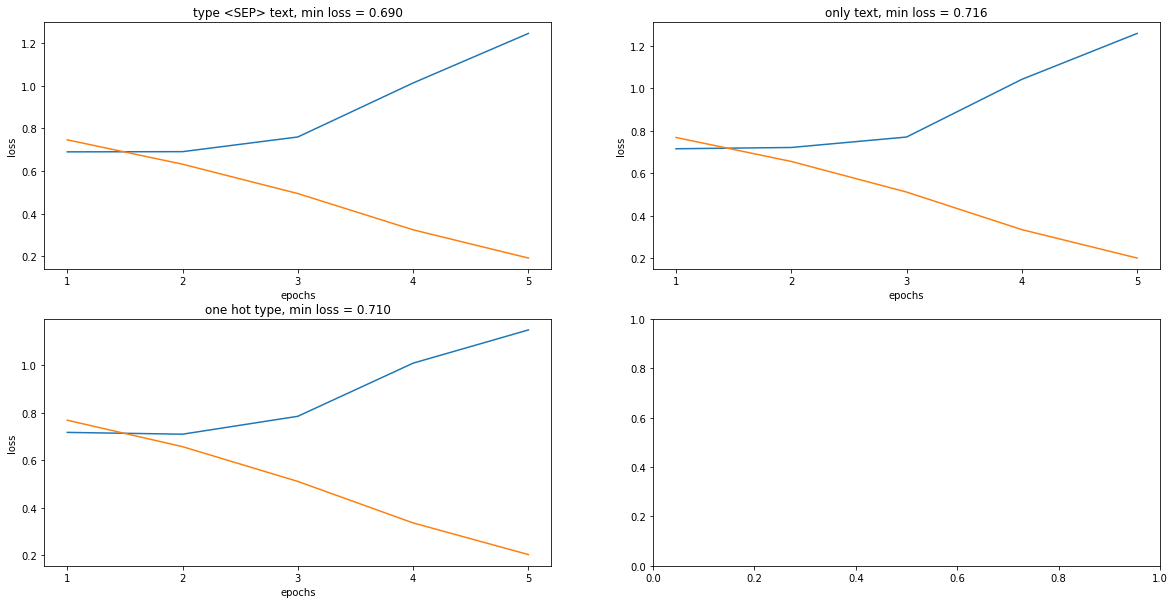

In [43]:
# Plot History


fig, axs = plt.subplots(2,2,figsize=(20,10))

#histories = {'sep_type': 'history_sep_025_dropout' , 'only_text':'history_onlytext_025_dropout', 'OH_type': 'history_oh_025_dropout'}


def plot_trainval(h, ax, title_name, y_lim=[None, None]):
    
    x = [j+1 for j,_ in enumerate(h['val_loss'])]
    ax.plot(x, h['val_loss'], label='val_loss')
    ax.plot(x, h['train_loss'], label='train_loss')
    
    ax.set_title(title_name + ', min loss = %.3f'%(np.min(h['val_loss'])))
    
    ax.set_ylim(y_lim[0], y_lim[1])
    
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.set_xticks(x)
    
plot_trainval(load_history('history_sep_025_dropout'), axs[0][0], 'type <SEP> text')
plot_trainval(load_history('history_onlytext_025_dropout'), axs[0][1], 'only text')
plot_trainval(load_history('history_oh_025_dropout'), axs[1][0], 'one hot type')

    

**figure notes**

It's unfortunate that the model overfits already after 1 epoch. This hints towards some local minumum solution. Atleast we know the model learnt 
something as the loss is lower than the baseline and the loss after the first batches during training.

We expect the \<SEP> model to perform the best on the test data, since it has the lowest validation loss.

### Test Data

In [44]:
ll, acc = baseline(training, test)
print('cross-entropy loss = %.3f, accuracy = %.3f'%(ll, acc))

cross-entropy loss = 1.024, accuracy = 0.556


In [45]:
## a bit ugly

def load_model(state_name):
    model_name = 'bert-base-uncased'
    if state_name.split('_')[1] == 'oh': #onehot model
        model = BERT_MODEL_OH(model_name, discourse_labels, discourse_types)
    else:
        model = BERT_MODEL(model_name, discourse_labels)
    model.to(device)
    
    state = torch.load(os.path.join('models', state_name))
    model.load_state_dict(state)
    return model

def get_test_loader(state_name, test_data):
    
    model_name = 'bert-base-uncased'
    tokenizer = BertTokenizerFast.from_pretrained(model_name)
    
    validation_batch_size = 16
    max_length = 256
    
    if state_name.split('_')[1] == 'sep':
        collate = BERT_TwoSentence_Collate(tokenizer, discourse_labels, max_length)
    elif  state_name.split('_')[1] == 'oh':
        collate = BERT_OneHotType_Collate(tokenizer, discourse_labels, discourse_types, max_length)
    elif  state_name.split('_')[1] == 'onlytext':
        collate = BERT_OnlyText_Collate(tokenizer, discourse_labels, max_length)
    
    loader =  DataLoader(DiscourseDataset(test),
        batch_size=validation_batch_size,
        shuffle=False,
        collate_fn=collate)
    
    return loader

def get_scores(state_name, test):
    
    model = load_model(state_name)
    loader =  get_test_loader(state_name, test_data)
    
    loss, acc, preds = evalute_model(model, loader, return_predictions=True)
    
    return loss, acc, preds
        
        
        

In [46]:
os.listdir('models')

['history_sep_025_dropout',
 'history_onlytext_025_dropout',
 'history_oh_025_dropout',
 'model_onlytext_025_dropout.pth',
 'model_oh_025_dropout.pth',
 'model_sep_025_dropout.pth',
 'results.csv']

In [47]:

if TRAIN_MODEL:
    results = pd.DataFrame(index=['sep', 'onlytext', 'oh'], columns = ['test_loss', 'test_acc'])



    print('Test data')
    print()
    llsep, accsep, preds_sep = get_scores('model_sep_025_dropout.pth', test)
    lltext, acctext, preds_onlytext = get_scores('model_onlytext_025_dropout.pth', test)
    lloh, accoh, preds_oh = get_scores('model_oh_025_dropout.pth', test)
    results.loc['sep'] = (llsep, accsep)
    results.loc['onlytext'] = (lltext, acctext)
    results.loc['oh'] = (lloh, accoh)
else:
    results = pd.read_csv('models/results.csv')

Test data



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight'

In [48]:
if TRAIN_MODEL:
    # Add some additional results to dataframe


    def get_trainval_results(history_name):

        h = load_history(history_name)
        h = pd.DataFrame(h)

        return h.loc[h['val_loss'].argmin(), :]


    h = get_trainval_results('history_sep_025_dropout')
    results.loc['sep', h.index ] = h

    h = get_trainval_results('history_onlytext_025_dropout')
    results.loc['onlytext', h.index ] = h

    h = get_trainval_results('history_oh_025_dropout')
    results.loc['oh', h.index ] = h

    results = results.loc[:, sorted(results.columns)]
    results.loc['baseline', :] = list(baseline(training, test))[::-1] + list(baseline(training, training))[::-1] + list(baseline(training, validation))[::-1]

In [49]:
if TRAIN_MODEL:
    results.to_csv('models/results.csv', index_label=False)

In [50]:
results

,test_acc,test_loss,train_acc,train_loss,val_acc,val_loss
sep,0.685,0.6994,0.665000,0.746510,0.691000,0.690010
onlytext,0.67,0.73082,0.657000,0.769250,0.680000,0.716110
oh,0.679,0.72179,0.703000,0.656890,0.687000,0.709540
baseline,0.55616,1.024268,0.571739,1.018376,0.575626,1.017346


Text(0, 0.5, 'accuracy')

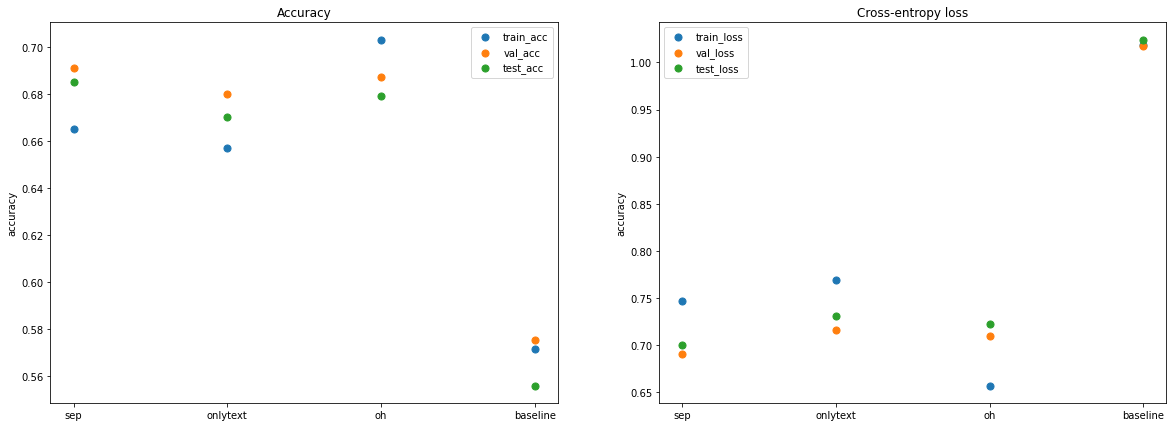

In [51]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,7))

xticks = list(results.index)
x = list(range(len(xticks)))
for metric in ['train_acc', 'val_acc', 'test_acc']:
    ax1.scatter(x, results[metric], s=50, label=metric)
ax1.legend()
ax1.set_title('Accuracy')
ax1.set_xticks(x)
ax1.set_xticklabels(xticks)
ax1.set_ylabel('accuracy')
               
               
xticks = list(results.index)
x = list(range(len(xticks)))
for metric in ['train_loss', 'val_loss', 'test_loss']:
    ax2.scatter(x, results[metric], s=50, label=metric)
ax2.legend()
ax2.set_title('Cross-entropy loss')
ax2.set_xticks(x)
ax2.set_xticklabels(xticks)
ax2.set_ylabel('accuracy')   
    
    
    

# Conclussions

It's hard to draw any definitive conclussion from these results. There are some observations to be made:
- Baseline it outperformed by all the models
- None of the models appears to suffer from any major overfitting. However we were only able to train the model for 1 epoch before overfitting would begin. This indicates that we get stuck in some local minimum
- 'sep' model appears to outperform 'oh' which in turn outperform 'onlytext'. In my opinion this is what was initially expected. However the differences are too small and could be due to variance.


As a next step I would try and find 
a way to combat the early overfitting of the model. This can be done by increasing dropout, different learning rate or finally using a more simple model. Id also like to cross validate the model to get a confidence interval for the results.


I think this is an interesting dataset as I think many other datasets have a similar structure, such as the WSD-datase. 